In [1]:
import pandas as pd
from pathlib import Path
from tnseq2.src.analysis import *

import numpy as np
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import chart_studio
import chart_studio.tools as tls
import chart_studio.plotly as py
import plotly.express as px
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [12]:
user_name = 'ansintsova'
api_key = "ZN7bd2M7Asfvb0iDMoPN"
tls.set_credentials_file(username=user_name, api_key=api_key)

# Normalize counts:

- Using lib10 mice for this analysis

1. Rarefaction -> is this appropriate, no one does this outside of microbiome data, and questionable for microbiome as well.
2. DESeq2 VST transformation -> more acceptable
3. TPMs

Compare this to results produced by DESeq2 alone

- Get the raw counts for library_10_2

In [2]:
root ="/Users/ansintsova/git_repos/nguyenb_tnseq/data/13_04_results"
results = "results"
counts = "counts"
dnaids = ['dnaid1315', 'dnaid1428', 'dnaid1429', 'dnaid2015', 'dnaid2016', 'dnaid2017', 'dnaid2018', 'dnaid2019',
         'dnaid2023', 'dnaid2024', 'dnaid2025', 'dnaid2026', 'dnaid2027', 'dnaid2028', 'dnaid2029' ]
cnt_df = load_files(dnaids, Path(root)/counts)
lib10_cnt = cnt_df[cnt_df.library == 'library_10_2'].copy()
lib10_cnt['sampleIDExp'] = lib10_cnt['sampleID'] + "_"+ lib10_cnt['dnaid'] + "_" + lib10_cnt['experiment']

## Identify good samples and subset count DF

In [3]:
control_file = Path(root)/'controls.txt'
corr_df, good_samples = calculate_correlation(lib10_cnt, control_file, for_each='sampleIDExp')
lib10_cnt = lib10_cnt[lib10_cnt.sampleIDExp.isin(good_samples)]

In [4]:
lib10_cnt.head()

,barcode,cnt,libcnt,sstart,sseqid,sstrand,multimap,ShortName,locus_tag,sampleName,...,experiment,mouse,day,tissue,dnaid,sampleID,DN,phenotype,conc,sampleIDExp
7749,AAAAAAACTGTAGTGCA,5233.0,1903.0,2051411.0,FQ312003.1,plus,False,SL1344_1940,SL1344_1940,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A
7750,AAAAAACGTCCGCGATG,2828.0,2152.0,3844829.0,FQ312003.1,plus,False,lpfD,SL1344_3602;pseudo=true,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A
7751,AAAAACATGCCACACTG,1684.0,2894.0,4014889.0,FQ312003.1,plus,False,AAAAACATGCCACACTG,NaN,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A
7752,AAAAACGCCGTTAAACT,2004.0,1078.0,1176550.0,FQ312003.1,plus,False,SL1344_1068,SL1344_1068,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A
7753,AAAAACTTTATACTTGA,2451.0,2353.0,36203.0,FQ312003.1,plus,False,SL1344_0033,SL1344_0033,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A


## Normalize data

### VST

In [5]:
sdf = lib10_cnt[['sampleID', 'mouse', 'day', 'tissue', 'dnaid', 'experiment', 'sampleIDExp']].set_index('sampleIDExp').drop_duplicates()
edf = (lib10_cnt[['barcode', 'sampleIDExp', 'experiment', 'mouse', 'day', 'tissue', 'dnaid', 'cnt']].drop_duplicates()
       .pivot(index='barcode', columns='sampleIDExp', values='cnt'))
edf = edf[list(sdf.index)]
edf = edf.fillna(0)
sdf.to_csv(Path(root)/results/'30_04_lib10_sdf.csv')
edf.to_csv(Path(root)/results/'30_04_lib10_edf.csv')
# # Run DESeq2
vst = pd.read_csv(Path(root)/results/'30_14_lib10_vsd.csv').rename({'Unnamed: 0':'barcode'}, axis=1).set_index('barcode')

## CLR

- ignoring 0 does not make sense for the transformation
- have to use pseudocounts


In [6]:
import numpy as np
from skbio.stats.composition import clr

def clr_on_array_with_0(a):
    a = np.ma.masked_equal(a, 0)
    transformed = clr(a)
    transformed[transformed.mask] = a.fill_value
    transformed = transformed.data
    return transformed


def clr_on_array_with_pseudocount(a):
    transformed = clr(a+1)
    return transformed

clr_df= edf.copy().apply(clr_on_array_with_0)
clr2_df = edf.copy().apply(clr_on_array_with_pseudocount)

/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/skbio/stats/composition.py:464: RuntimeWarning:

divide by zero encountered in log



In [130]:
clr2_df.head()

sampleIDExp,ad927_d1_dnaid2017_TV4592A,ad927_d2_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,ad926_d2_dnaid2017_TV4592A,unenriched_inoculum_d0_dnaid2017_TV4592A,ad928_d2_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad930_d2_dnaid2017_TV4592A,inoculum_d0_dnaid2017_TV4592A,...,am731_d2_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A,am727_d2_dnaid2028_TV5585A,am729_d3_dnaid2029_TV5585A,am728_d3_dnaid2029_TV5585A,am727_d3_dnaid2029_TV5585A,inoculum_d0_dnaid2029_TV5585A,am730_d3_dnaid2029_TV5585A,am732_d3_dnaid2029_TV5585A,am732_d4_dnaid2029_TV5585A
barcode,,,,,,,,,,,,,,,,,,,,,
AAAAAAACTGTAGTGCA,2.669626,2.591180,2.258865,2.125927,1.438977,2.037621,2.113600,2.211051,2.156135,1.976024,...,2.850837,5.272083,2.419601,2.949967,2.459781,2.992276,2.860331,4.665598,7.079576,6.056215
AAAAAACGTCCGCGATG,2.054373,2.118428,2.248445,2.422924,1.413975,2.030366,2.057739,2.131770,2.229922,2.290112,...,4.343288,-0.608880,2.657648,3.341671,2.202963,3.072319,2.842281,1.368769,3.333971,7.145209
AAAAACATGCCACACTG,1.536216,1.203728,2.582836,2.455208,1.530059,2.147568,2.463952,2.174684,2.253485,2.437405,...,3.722366,5.629295,2.993279,2.622157,3.133530,3.141788,3.010985,0.672937,4.550717,4.765198
AAAAACGCCGTTAAACT,1.710094,1.328111,1.267033,1.316313,0.566823,0.973800,1.254132,0.982386,0.811116,1.152718,...,-4.621663,-0.871244,1.249208,1.507102,1.286672,1.088656,1.931019,1.387361,-2.937017,-2.556652
AAAAACTTTATACTTGA,1.911354,1.780043,2.187869,2.393603,1.377300,1.733179,2.056841,1.742092,2.064114,2.175242,...,4.107248,0.463757,3.000034,3.329259,2.292911,3.331137,2.835263,1.319308,1.033275,-1.458039


In [7]:
clr_df.ad927_d1_dnaid2017_TV4592A[clr_df.ad927_d1_dnaid2017_TV4592A==0]

barcode
AAAACAGCAAAGACTGC    0.0
AAAATGCGCACTACGAA    0.0
AAAATTATAAGTGCGAT    0.0
AAAATTCTTTCTCCCCG    0.0
AAACGAATCCCTTTCCG    0.0
                    ... 
TTGGATTCAACCGGCTC    0.0
TTTATGAGCGGCTATGA    0.0
TTTGCGGGGACGATATG    0.0
TTTTCGGACCATTGAAG    0.0
TTTTTAATCCAAAGCCT    0.0
Name: ad927_d1_dnaid2017_TV4592A, Length: 280, dtype: float64

In [8]:
px.scatter(x=clr2_df.ad927_d1_dnaid2017_TV4592A, y = clr_df.ad927_d1_dnaid2017_TV4592A)

In [29]:
px.scatter(x=clr2_df.ad927_d1_dnaid2017_TV4592A, y = logbpm.ad927_d1_dnaid2017_TV4592A)

In [31]:
px.scatter(x=clr2_df.ad927_d1_dnaid2017_TV4592A, y = vst.ad927_d1_dnaid2017_TV4592A)

In [28]:
px.scatter(x=np.log2(rare.ad927_d1_dnaid2017_TV4592A+1), y = vst.ad927_d1_dnaid2017_TV4592A)

### Rarefaction

In [7]:
lib10_cnt.head()

,barcode,cnt,libcnt,sstart,sseqid,sstrand,multimap,ShortName,locus_tag,sampleName,...,experiment,mouse,day,tissue,dnaid,sampleID,DN,phenotype,conc,sampleIDExp
7749,AAAAAAACTGTAGTGCA,5233.0,1903.0,2051411.0,FQ312003.1,plus,False,SL1344_1940,SL1344_1940,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A
7750,AAAAAACGTCCGCGATG,2828.0,2152.0,3844829.0,FQ312003.1,plus,False,lpfD,SL1344_3602;pseudo=true,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A
7751,AAAAACATGCCACACTG,1684.0,2894.0,4014889.0,FQ312003.1,plus,False,AAAAACATGCCACACTG,NaN,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A
7752,AAAAACGCCGTTAAACT,2004.0,1078.0,1176550.0,FQ312003.1,plus,False,SL1344_1068,SL1344_1068,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A
7753,AAAAACTTTATACTTGA,2451.0,2353.0,36203.0,FQ312003.1,plus,False,SL1344_0033,SL1344_0033,dnaid2017_65,...,TV4592A,ad927,d1,feces,dnaid2017,ad927_d1,NaN,NaN,NaN,ad927_d1_dnaid2017_TV4592A


In [8]:
good_samples_rare = list(good_samples).copy()
good_samples_rare.remove('am487_d1_dnaid2027_TV5563A') #Has too few reads
lib10_cnt_rare = lib10_cnt[lib10_cnt.sampleIDExp.isin(good_samples_rare)]
edf_rare = (lib10_cnt_rare[['barcode', 'sampleIDExp', 'experiment', 'mouse', 'day', 'tissue', 'dnaid', 'cnt']].drop_duplicates()
       .pivot(index='barcode', columns='sampleIDExp', values='cnt'))
edf_rare = edf_rare.fillna(0)
edf_rare.to_csv(Path(root)/'results/03_05_lib10_rare_edf.csv')
## Rarefy with vegan in R

#rare = pd.read_csv(Path(root)/'results/05_05_lib10_rarefied_edf.csv').rename({'Unnamed: 0':'barcode'}, axis=1).set_index('barcode')

rare = (pd.read_csv(Path(root)/'results/05_05_lib10_rarefied_edf.csv')
        .set_index('Unnamed: 0').T)
rare.index.name = 'barcode'

### TPMs (or barcodes per million, BPMs)

In [9]:
per_million = edf.sum()/1000000
bpm = edf/per_million
logbpm = np.log2(bpm +1)

In [10]:
annotation_df = cnt_df[['barcode', 'ShortName', 'locus_tag', 'phenotype', 'conc']].drop_duplicates()

- Calculate mean for the inoculum samples
- Calculate fitness

In [11]:
import statsmodels
def gene_ranksums(gene_values, wt_values):
    return ranksums(gene_values, wt_values)[1]

def fdr_correction(pvals):
    return statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='fdr_bh')[1]


def get_median_for_gene_on_a_day(df, annotation, day, grp_by='ShortName'):
    df = df.merge(annotation, on='barcode')
    samples = dict.fromkeys(([c for c in df.columns if day in c]), ['median'])
    day_median_value = df.groupby('ShortName').agg(samples)
    day_median_value.columns = [c[0] for c in day_median_value.columns]
    return day_median_value


def get_fitness(cnts, annotation, day, good_samples=good_samples, hits=0.05, rare=False):
    # Calculate a mean value for all inoculum samples
    
    cnts['inoculum'] = cnts[[c for c in cnts.columns if 'd0' in c]].mean(axis=1)
    cnts = cnts.dropna(subset=['inoculum'])
    cnts = cnts[cnts.inoculum > 0]
    # Caclucalte fitness for each barcode
    if rare:
        fitness = cnts.apply(lambda x: x/cnts['inoculum']).reset_index()
    else:
        fitness = cnts.apply(lambda x: 2**x/2**cnts['inoculum']).reset_index()
    # Add gene annotation
    
        
    fitness = fitness.merge(annotation, on='barcode')
    # Calculate fitness for each gene
    # Drop controls for now
    gene_df = fitness[fitness.phenotype.isna()]
    # Calculate median value for each ShortName
    samples = dict.fromkeys(([c for c in fitness.columns if day in c]), ['median'])
    day_fitness = gene_df.groupby('ShortName').agg(samples)
    day_fitness.columns = [c[0] for c in day_fitness.columns]

    # Calculate median fitness for wt barcodes
    wt_fitness = fitness[fitness.phenotype == 'wt'][[c for c in good_samples if day in c]].median()
    
    # Calculate rnasksums test for wt vs each gene, multi-test correction using Benjamini/Hochberg (non-negative)
    pvals = day_fitness.apply(gene_ranksums,  axis=1, wt_values = wt_fitness)
    padj = fdr_correction(pvals.values)
    results = pd.DataFrame([pvals.values, padj], columns=pvals.index, index=['pval', 'padj']).T
    
    # Calculate CI
    day_ci = day_fitness.apply(lambda x: x/wt_fitness[x.name])
    ssa_fitness = fitness[fitness.phenotype == 'ssaV_invG'][[c for c in good_samples if day in c]].median()
    ssa_ci = ssa_fitness/wt_fitness
    
    pvals_ci = day_ci.apply(gene_ranksums,  axis=1, wt_values = ssa_ci)
    ci_res = pd.DataFrame([pvals_ci.values, fdr_correction(pvals_ci.values)], columns=pvals.index, index=['ci_pval', 'ci_padj']).T
    
    # Calculate median and mean fitness and median and mean CI
    
    day_fitness['median_fitness'] = day_fitness.median(axis=1)
    day_fitness['mean_fitness'] =  day_fitness.mean(axis=1)
    day_fitness = day_fitness.merge(results, left_index=True, right_index=True)
    day_ci['median_CI'] = day_ci.median(axis=1)
    day_ci['mean_CI'] = day_ci.mean(axis=1)
    
    day_ci = day_ci.merge(ci_res, left_index=True, right_index=True)
    controls = pd.concat([wt_fitness, ssa_fitness], axis=1)
    controls.columns = ['wt', 'ssaV_invG']
    day_fitness['hits'] = day_fitness['padj'] < hits
    day_ci['hits'] = day_ci['ci_padj'] < hits
    return day_fitness, day_ci, controls, ssa_ci

### Looking at the Inoculum

In [12]:
# VST

vst_cnt_d0 = get_median_for_gene_on_a_day(vst, annotation_df, 'd0')
vst_inoculum_cnts = vst_cnt_d0.median(axis=1)
vst_inoculum_cnts.name = 'median_inoculm_value'

# Rare
rare_cnt_d0 = get_median_for_gene_on_a_day(rare, annotation_df, 'd0')
rare_inoculum_cnts = rare_cnt_d0.median(axis=1)
rare_inoculum_cnts.name = 'median_inoculm_value'
# BPM
bpm_cnt_d0 = get_median_for_gene_on_a_day(logbpm, annotation_df, 'd0')
bpm_inoculum_cnts = bpm_cnt_d0.median(axis=1)
bpm_inoculum_cnts.name = 'median_inoculm_value'
inoculum_cnts = pd.DataFrame([vst_inoculum_cnts, rare_inoculum_cnts, bpm_inoculum_cnts], index=['VST', 'RARE', 'BPM']).T

In [13]:
inoculum_cnts.head()

,VST,RARE,BPM
ShortName,,,
AAAAACATGCCACACTG,11.710378,1333.0,9.369769
AAAACGCAGCGCTTGCC,5.500596,1.0,0.660882
AAAACTTCATGTACAGA,10.769591,680.5,8.400694
AAAATTCTTTCTCCCCG,5.175039,0.0,0.000000
AAACAATAGGGGGGTAG,5.458782,0.5,0.364519


In [14]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def scatter_plot(normalization=['VST', 'RARE', 'BPM']):
    fig = px.histogram(inoculum_cnts, x=normalization, nbins=100)
    fig.show()

interactive(children=(Dropdown(description='normalization', options=('VST', 'RARE', 'BPM'), value='VST'), Outp…

### Looking at Day 1

In [15]:
vst_inoculum_cnts.name = 'median_inoculm_value'

In [16]:
# VST
vst_fit_d1, vst_ci_d1, vst_controls_d1, vst_ssa_ci_d1 = get_fitness(vst, annotation_df, 'd1', good_samples=good_samples)

vst_fit_d1 = vst_fit_d1.merge(2**vst_inoculum_cnts, on='ShortName')

# RARE

rare_fit_d1, rare_ci_d1, rare_controls_d1, rare_ssa_ci_d1 = get_fitness(rare, annotation_df, 'd1', good_samples=good_samples_rare, rare=True)

rare_fit_d1 = rare_fit_d1.merge(rare_inoculum_cnts, on='ShortName')
# BPM

bpm_fit_d1, bpm_ci_d1, bpm_controls_d1, bpm_ssa_ci_d1 = get_fitness(logbpm, annotation_df, 'd1', good_samples=good_samples)

bpm_fit_d1 = bpm_fit_d1.merge(bpm_inoculum_cnts, on='ShortName')

In [17]:
vst_fit_d1.hits.sum()

126

In [20]:
rare_ci_d1.loc['dcuR']

ad926_d1_dnaid2017_TV4592A      0.442079
ad927_d1_dnaid2017_TV4592A             0
ad928_d1_dnaid2017_TV4592A       1.44595
ad929_d1_dnaid2017_TV4592A       1.18802
ad930_d1_dnaid2017_TV4592A      0.849779
am483_d1_dnaid2027_TV5563A             0
am484_d1_dnaid2027_TV5563A       1.77841
am485_d1_dnaid2027_TV5563A       1.24589
am486_d1_dnaid2027_TV5563A             0
am488_d1_dnaid2027_TV5563A             0
am727_d1_dnaid2028_TV5585A             0
am728_d1_dnaid2028_TV5585A             0
am729_d1_dnaid2028_TV5585A             0
am730_d1_dnaid2028_TV5585A             0
am731_d1_dnaid2028_TV5585A             0
am732_d1_dnaid2028_TV5585A             0
median_CI                              0
mean_CI                         0.408831
ci_pval                       0.00199826
ci_padj                       0.00750958
hits                                True
Name: dcuR, dtype: object

In [21]:
vst_controls_d1 

,wt,ssaV_invG
ad926_d1_dnaid2017_TV4592A,0.948329,1.341165
ad927_d1_dnaid2017_TV4592A,0.627835,0.911414
ad928_d1_dnaid2017_TV4592A,1.157529,1.603045
ad929_d1_dnaid2017_TV4592A,1.081703,1.387641
ad930_d1_dnaid2017_TV4592A,0.988722,1.558734
am483_d1_dnaid2027_TV5563A,0.894369,1.043453
am484_d1_dnaid2027_TV5563A,1.005122,1.172333
am485_d1_dnaid2027_TV5563A,0.839895,1.355144
am486_d1_dnaid2027_TV5563A,0.889777,1.262259
am487_d1_dnaid2027_TV5563A,9.283488,9.375278


In [126]:
vst_fitness = px.scatter(vst_fit_d1, x='median_fitness', y='padj',color='hits', size='median_inoculm_value', 
                     log_y=True, hover_data=[vst_fit_d1.index, vst_fit_d1.median_inoculm_value])
vst_fitness.update_yaxes(autorange="reversed")

vst_fitness.write_html(f'{root}/results/test.html')

In [83]:
deseq_d1.head()

,ShortName,log2FoldChange,padj
2,AAAAACATGCCACACTG,0.874040,0.999936
9,AAAACGCAGCGCTTGCC,-0.196088,0.999936
11,AAAACTTCATGTACAGA,1.049991,0.999936
20,AAAATTCTTTCTCCCCG,-1.683521,0.999936
23,AAACAATAGGGGGGTAG,0.208786,0.999936


In [121]:
@interact
def fitness_plot(normalization=['VST', 'RARE', 'BPM',]):
    if normalization == 'VST':
        df = vst_fit_d1.sort_values('hits')
        
    elif normalization =='RARE':
        df = rare_fit_d1.sort_values('hits')

    else:
        df = bpm_fit_d1.sort_values('hits')
    fig = px.scatter(df, x='median_fitness', y='padj',color='hits',
                     color_discrete_map={True: 'red', False:'blue'},  size='median_inoculm_value',
                      log_y=True,  template = "simple_white", hover_data=[df.index, df.median_inoculm_value])
    fig.update_yaxes(autorange="reversed")
    fig.show()

interactive(children=(Dropdown(description='normalization', options=('VST', 'RARE', 'BPM'), value='VST'), Outp…

In [101]:
vst_ci_d1.sample(5)

,ad927_d1_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,am484_d1_dnaid2027_TV5563A,am483_d1_dnaid2027_TV5563A,am488_d1_dnaid2027_TV5563A,am485_d1_dnaid2027_TV5563A,am486_d1_dnaid2027_TV5563A,...,am727_d1_dnaid2028_TV5585A,am730_d1_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A,median_CI,mean_CI,ci_pval,ci_padj,hits
ShortName,,,,,,,,,,,,,,,,,,,,,
SL1344_0547,4.702937,1.061584,1.338590,1.132117,1.201639,0.715178,0.957922,1.186713,3.252551,0.960029,...,1.208873,0.099433,0.661761,1.223980,2.950058,1.177925,1.401644,0.617476,0.705686,False
SL1344_0674,1.770973,1.020627,1.263149,0.994121,1.340622,0.764976,1.140434,0.880682,1.662882,0.864142,...,0.943279,1.344221,1.227697,0.801582,0.225271,0.994121,1.003461,0.173666,0.310199,False
CCGTATGAGACCACAGC,1.783284,1.056273,1.248361,1.072629,1.478197,1.000636,1.004914,0.842709,0.875993,1.392299,...,0.902608,1.286263,1.174763,0.767020,0.215558,1.004914,1.017310,0.184815,0.318657,False
amiC,1.905031,1.076569,1.147137,0.979847,1.403758,1.065013,0.981702,1.005654,1.045373,0.986768,...,1.077135,1.534973,1.401914,0.915330,0.257238,1.045373,1.082232,0.234715,0.362339,False
ssaI,3.863622,1.110642,0.943718,0.980039,1.104416,0.716771,0.983238,0.971094,2.616833,0.775114,...,1.200306,2.577333,0.654142,0.936082,0.013112,0.971094,1.187366,0.109239,0.242638,False


In [134]:
vst_ci_d1.head()

,ad927_d1_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,am484_d1_dnaid2027_TV5563A,am483_d1_dnaid2027_TV5563A,am488_d1_dnaid2027_TV5563A,am485_d1_dnaid2027_TV5563A,am486_d1_dnaid2027_TV5563A,...,am727_d1_dnaid2028_TV5585A,am730_d1_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A,median_CI,mean_CI,ci_pval,ci_padj,hits
ShortName,,,,,,,,,,,,,,,,,,,,,
AAAAACATGCCACACTG,0.445705,1.027581,1.230238,0.720786,0.905489,1.676952,1.825032,1.766877,0.876016,1.401828,...,1.526941,0.279522,2.750276,1.636850,3.971351,1.230238,1.352708,0.641940,0.726173,False
AAAACGCAGCGCTTGCC,1.688417,1.110460,1.611897,1.114833,1.474495,1.121772,1.223419,0.930629,0.771137,1.144434,...,0.794567,1.132299,1.034145,0.675209,0.189756,1.110460,1.019227,0.248558,0.373927,False
AAAACTTCATGTACAGA,0.216036,1.134500,1.004346,1.132161,1.594486,1.576099,1.741964,1.171126,0.352760,1.073735,...,1.337924,18.760276,0.969725,1.749639,1.310826,1.134500,2.094481,0.931380,0.947949,False
AAAATTCTTTCTCCCCG,1.470439,1.092769,0.973494,0.956078,1.076839,0.918489,1.032228,1.057413,1.099176,1.037555,...,1.132573,1.613974,1.474067,0.962440,0.270477,1.037555,1.010797,0.208685,0.342607,False
AAACAATAGGGGGGTAG,1.641905,0.996190,1.099575,0.907687,0.778034,1.144608,1.149501,1.378021,1.567994,0.945856,...,1.032476,1.471331,1.816850,1.084411,0.246572,1.084411,1.076785,0.480131,0.591702,False


In [135]:
@interact
def fitness_plot(normalization=['VST', 'RARE', 'BPM',]):
    if normalization == 'VST':
        df = vst_ci_d1.sort_values('hits')
        
    elif normalization =='RARE':
        df = rare_ci_d1.sort_values('hits')

    else:
        df = bpm_ci_d1.sort_values('hits')
    fig = px.scatter(df, x='median_CI', y='ci_padj',color='hits',
                     color_discrete_map={True: px.colors.qualitative.Plotly[1], False:px.colors.qualitative.Plotly[0]}, 
                      log_y=True, template = "simple_white", hover_data=[df.index])
    fig.update_yaxes(autorange="reversed")
    fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='black')),
                  selector=dict(mode='markers'))
    fig.show()

interactive(children=(Dropdown(description='normalization', options=('VST', 'RARE', 'BPM'), value='VST'), Outp…

In [96]:
fig = px.scatter(deseq_d1, x='median_fitness', y='padj',color='hits',
                     color_discrete_map={True: 'red', False:'blue'},  
                      log_y=True,  hover_data={'gene':df.ShortName})
fig.update_yaxes(autorange="reversed")
fig.show()

In [47]:
vst_fit_d1.hits.sum()
rare_fit_d1.hits.sum()

732

In [54]:
vst_fit_d1[(vst_fit_d1.hits == True)& (vst_fit_d1.median_inoculm_value < 50) ]

,ad927_d1_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,am484_d1_dnaid2027_TV5563A,am483_d1_dnaid2027_TV5563A,am488_d1_dnaid2027_TV5563A,am485_d1_dnaid2027_TV5563A,am486_d1_dnaid2027_TV5563A,...,am730_d1_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A,median_fitness,mean_fitness,pval,padj,hits,median_inoculm_value
ShortName,,,,,,,,,,,,,,,,,,,,,
recB,0.772211,0.772211,0.772211,0.772211,0.772211,0.772211,0.772211,0.772211,0.772211,0.772211,...,0.772211,0.772211,0.772211,0.772211,0.772211,0.772211,0.00128,0.023233,True,46.844632


In [53]:
rare_fit_d1[(rare_fit_d1.hits == True) & (rare_fit_d1.median_inoculm_value < 50)]

,ad926_d1_dnaid2017_TV4592A,ad927_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,am483_d1_dnaid2027_TV5563A,am484_d1_dnaid2027_TV5563A,am485_d1_dnaid2027_TV5563A,am486_d1_dnaid2027_TV5563A,am488_d1_dnaid2027_TV5563A,...,am729_d1_dnaid2028_TV5585A,am730_d1_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A,median_fitness,mean_fitness,pval,padj,hits,median_inoculm_value
ShortName,,,,,,,,,,,,,,,,,,,,,
AAAACGCAGCGCTTGCC,1.350000,0.450000,1.650000,2.400000,0.450000,0.600000,0.750000,0.0,0.450000,0.000000,...,0.0,0.0,0.0,0.0,0.225000,0.489706,0.010382,0.031263,True,1.0
AAAATTCTTTCTCCCCG,0.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,1.058824,0.002569,0.010712,True,0.0
AAACGAAGAACAATCCC,0.600000,0.200000,1.000000,3.000000,0.200000,0.000000,0.600000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.329412,0.000396,0.002952,True,1.5
AAACGCTCTTCGACCGC,1.875000,0.375000,1.125000,2.625000,0.000000,0.375000,0.000000,0.0,1.125000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.441176,0.015861,0.042418,True,0.5
AAACTGGGCACGCGCAA,0.300000,0.600000,0.600000,0.600000,0.000000,0.000000,0.300000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.141176,0.000010,0.000288,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yjfI,0.000000,1.200000,0.600000,1.800000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.211765,0.000456,0.003324,True,0.0
ykgB,2.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.666667,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.196078,0.000089,0.001117,True,1.0
yohG,0.514286,0.171429,0.342857,1.200000,0.171429,0.000000,0.342857,0.0,0.685714,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.201681,0.000104,0.001207,True,0.5


In [131]:
from plotly.subplots import make_subplots
@interact
def fitness_plot(normalization=['VST', 'RARE', 'BPM']):
    if normalization == 'VST':
        df = vst_ci_d1
        cntrl = vst_ssa_ci_d1
    elif normalization =='RARE':
        df = rare_ci_d1
        cntrl = rare_ssa_ci_d1
    else:
        df = bpm_ci_d1
        cntrl = bpm_ssa_ci_d1
  
    fig = px.scatter(df, x='median_CI', y='ci_padj',color='hits', 
                     log_y=True, log_x=True, hover_data=[df.index])
    fig.update_yaxes(autorange="reversed")
    #fig.add_scatter(x=cntrl, y = [2.96]*len(cntrl))
    fig.show()

interactive(children=(Dropdown(description='normalization', options=('VST', 'RARE', 'BPM'), value='VST'), Outp…

In [251]:
vst_ssa_ci_d1

ad926_d1_dnaid2017_TV4592A    1.050227
ad927_d1_dnaid2017_TV4592A    1.051195
ad928_d1_dnaid2017_TV4592A    1.031999
ad929_d1_dnaid2017_TV4592A    1.028422
ad930_d1_dnaid2017_TV4592A    1.060309
am483_d1_dnaid2027_TV5563A    1.019993
am484_d1_dnaid2027_TV5563A    1.026497
am485_d1_dnaid2027_TV5563A    1.061107
am486_d1_dnaid2027_TV5563A    1.046702
am487_d1_dnaid2027_TV5563A    1.038799
am488_d1_dnaid2027_TV5563A    1.004899
am727_d1_dnaid2028_TV5585A    1.045686
am728_d1_dnaid2028_TV5585A    0.997048
am729_d1_dnaid2028_TV5585A    0.981528
am730_d1_dnaid2028_TV5585A    0.821764
am731_d1_dnaid2028_TV5585A    0.818195
am732_d1_dnaid2028_TV5585A    0.980045
dtype: float64

In [224]:
fig = px.scatter(vst_controls_d1, x='wt', y='ycoord', 
                     log_y=True, hover_data=[vst_controls_d1.index])
fig.update_yaxes(autorange="reversed")
fig.show()

In [230]:
test1 = vst_controls_d1.T
vst_controls_d1['hits'] = 'wt'

test = pd.concat([vst_ci_d1, vst_controls_d1.T])
vst_controls_d1

,wt,ssaV_invG,ycoord,padj,hits
ad926_d1_dnaid2017_TV4592A,0.993400,1.043295,2.96,2.96,wt
ad927_d1_dnaid2017_TV4592A,0.942367,0.990612,2.96,2.96,wt
ad928_d1_dnaid2017_TV4592A,1.022284,1.054996,2.96,2.96,wt
ad929_d1_dnaid2017_TV4592A,1.009525,1.038217,2.96,2.96,wt
ad930_d1_dnaid2017_TV4592A,0.998205,1.058406,2.96,2.96,wt
am483_d1_dnaid2027_TV5563A,0.985376,1.005077,2.96,2.96,wt
am484_d1_dnaid2027_TV5563A,0.999043,1.025514,2.96,2.96,wt
am485_d1_dnaid2027_TV5563A,0.981761,1.041753,2.96,2.96,wt
am486_d1_dnaid2027_TV5563A,0.983285,1.029206,2.96,2.96,wt
am487_d1_dnaid2027_TV5563A,1.285943,1.335836,2.96,2.96,wt


In [217]:
rare_ssa_ci_d1

ad926_d1_dnaid2017_TV4592A    1.450831
ad927_d1_dnaid2017_TV4592A    1.418124
ad928_d1_dnaid2017_TV4592A    1.376602
ad929_d1_dnaid2017_TV4592A    1.253350
ad930_d1_dnaid2017_TV4592A    1.539939
am483_d1_dnaid2027_TV5563A    1.184710
am484_d1_dnaid2027_TV5563A    1.177731
am485_d1_dnaid2027_TV5563A    1.581403
am486_d1_dnaid2027_TV5563A    1.462760
am488_d1_dnaid2027_TV5563A    1.204113
am727_d1_dnaid2028_TV5585A    1.431242
am728_d1_dnaid2028_TV5585A    0.957579
am729_d1_dnaid2028_TV5585A    0.901977
am730_d1_dnaid2028_TV5585A    0.000000
am731_d1_dnaid2028_TV5585A    0.123404
am732_d1_dnaid2028_TV5585A    0.928238
dtype: float64

In [215]:
px.box(vst_controls_d1, y='wt',points='all',)

In [212]:
? px.box

In [56]:
logbmp_fit1, logbmp_ci1, logbmp_controls, logbmp_ssa_ci = get_fitness(logbpm, annotation_df, 'd1')

In [68]:
logbmp_res = logbmp_fit1[logbmp_fit1.padj<0.05].sort_values('padj')

In [102]:
vst = get_fitness(vst_df, annotation_df, 'd1')
vst.head()

,barcode,ad927_d1_dnaid2017_TV4592A,ad927_d2_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,ad926_d2_dnaid2017_TV4592A,unenriched_inoculum_d0_dnaid2017_TV4592A,ad928_d2_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad930_d2_dnaid2017_TV4592A,...,am727_d3_dnaid2029_TV5585A,inoculum_d0_dnaid2029_TV5585A,am730_d3_dnaid2029_TV5585A,am732_d3_dnaid2029_TV5585A,am732_d4_dnaid2029_TV5585A,inoculum,ShortName,locus_tag,phenotype,conc
0,AAAAAAACTGTAGTGCA,1.004205,1.029926,0.989300,1.004541,0.990659,1.014084,1.002910,1.009704,1.016710,...,1.024327,1.015431,1.202184,1.385296,1.271525,1.0,SL1344_1940,SL1344_1940,NaN,NaN
1,AAAAAACGTCCGCGATG,0.920677,0.962531,0.977867,1.030054,0.977466,1.002770,0.985876,0.989774,1.015150,...,1.023459,1.002802,0.798871,0.913837,1.393045,1.0,lpfD,SL1344_3602;pseudo=true,NaN,NaN
2,AAAAACATGCCACACTG,0.846829,0.842036,1.001625,1.017225,0.975339,1.000448,1.018138,0.978823,1.001514,...,1.015164,1.006606,0.715937,1.042584,1.081803,1.0,AAAAACATGCCACACTG,NaN,NaN,NaN
3,AAAAACGCCGTTAAACT,0.999374,0.987342,0.979230,1.019409,0.996205,0.996362,1.011077,0.970371,0.962837,...,0.901020,1.015434,0.908847,0.536641,0.536641,1.0,SL1344_1068,SL1344_1068,NaN,NaN
4,AAAAACTTTATACTTGA,0.907893,0.926489,0.974855,1.030982,0.977323,0.971337,0.990069,0.947382,0.999502,...,1.059466,1.006328,0.797032,0.676940,0.530909,1.0,SL1344_0033,SL1344_0033,NaN,NaN


In [70]:
vst_fit1, vst_ci1, vst_controls, vst_ssa_ci = 

In [85]:
rare_fit1, rare_ci1, rare_controls, rare_ssa_ci = get_fitness(rare, annotation_df, 'd1', good_samples_rare)

In [86]:
rare_res = rare_fit1[rare_fit1.padj<0.05].sort_values('padj')

In [73]:
vst_sig = vst_fit1[vst_fit1.padj < 0.05].sort_values('padj')

In [87]:
len(set(vst_sig.index).intersection(set(rare_res.index)))

103

In [88]:
rare_res.shape

(557, 20)

In [150]:
# Calculate a mean value for all inoculum samples
cnts = rare.copy()
cnts['inoculum'] = cnts[[c for c in cnts.columns if 'd0' in c]].mean(axis=1)
cnts = cnts[cnts.inoculum > 10]
cnts2 = cnts.reset_index().merge(annotation_df, on='barcode')
day='d1'
# Caclucalte fitness for each barcode
fitness = cnts.apply(lambda x: x/cnts['inoculum']).reset_index()
# Add gene annotation
fitness = fitness.merge(annotation_df, on='barcode')
# Calculate fitness for each gene
# Drop controls for now
gene_df = fitness[fitness.phenotype.isna()]
#Calculate median value for each ShortName
samples = dict.fromkeys(([c for c in fitness.columns if day in c]), ['median'])
day_fitness = gene_df.groupby('ShortName').agg(samples)
day_fitness.columns = [c[0] for c in day_fitness.columns]

# Calculate median fitness for wt barcodes
wt_fitness = fitness[fitness.phenotype == 'wt'][[c for c in good_samples_rare if day in c]].median()

# Calculate rnasksums test for wt vs each gene, multi-test correction using Benjamini/Hochberg (non-negative)
pvals = day_fitness.apply(gene_ranksums,  axis=1, wt_values = wt_fitness)
padj = fdr_correction(pvals.values)
results = pd.DataFrame([pvals.values, padj], columns=pvals.index, index=['pval', 'padj']).T

# Calculate CI
day_ci = day_fitness.apply(lambda x: x/wt_fitness[x.name])
ssa_fitness = fitness[fitness.phenotype == 'ssaV_invG'][[c for c in good_samples_rare if day in c]].median()
ssa_ci = ssa_fitness/wt_fitness

pvals_ci = day_ci.apply(gene_ranksums,  axis=1, wt_values = ssa_ci)
ci_res = pd.DataFrame([pvals_ci.values, fdr_correction(pvals_ci.values)], columns=pvals.index, index=['ci_pval', 'ci_padj']).T
day_fitness['median_fitness'] = day_fitness.median(axis=1)
day_fitness['mean_fitness'] =  day_fitness.mean(axis=1)
day_fitness = day_fitness.merge(results, left_index=True, right_index=True)
day_ci['median_CI'] = day_ci.median(axis=1)
day_ci['mean_CI'] = day_ci.mean(axis=1)
day_ci = day_ci.merge(ci_res, left_index=True, right_index=True)
controls = pd.concat([wt_fitness, ssa_fitness], axis=1)
controls.columns = ['wt', 'ssaV_invG']


In [73]:
vst_fit1.loc[day_fitness.index].head()

,ad927_d1_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,am484_d1_dnaid2027_TV5563A,am483_d1_dnaid2027_TV5563A,am488_d1_dnaid2027_TV5563A,am485_d1_dnaid2027_TV5563A,am486_d1_dnaid2027_TV5563A,...,am729_d1_dnaid2028_TV5585A,am727_d1_dnaid2028_TV5585A,am730_d1_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A,median_fitness,mean_fitness,pval,padj
ShortName,,,,,,,,,,,,,,,,,,,,,
AAAAACATGCCACACTG,0.846829,1.001625,1.018138,0.978823,0.998102,1.061936,1.059123,1.053838,0.964566,1.029457,...,1.011537,1.025362,0.783565,1.066979,1.054250,1.319043,1.018138,1.007668,0.234715,0.501858
AAAACTTCATGTACAGA,0.741135,1.014749,0.992976,1.036393,1.072262,1.058754,1.057730,1.004101,0.842813,0.996737,...,1.014747,1.010061,1.319032,0.935524,1.067346,1.198819,1.014749,1.030164,0.081965,0.289793
AAACGGCCGAGTTCGAG,0.948968,1.013673,1.021552,0.998674,0.994477,0.975490,0.947853,0.933209,1.035442,1.009669,...,1.047175,1.024097,0.812955,0.923076,0.995677,0.494289,0.994477,0.938498,0.569819,0.761911
AAACGTCCCCACACGGG,1.125495,0.988679,1.010673,1.007314,0.988328,1.010327,1.047046,0.948769,1.183885,1.008714,...,0.994773,1.007007,1.057201,1.021704,1.040429,1.140465,1.010327,1.028356,0.055925,0.235686
AAAGAAGCTATAAACTA,0.968490,1.010692,0.936294,0.948411,0.963252,0.963934,1.024217,0.996399,1.283568,0.925076,...,1.010400,1.092573,1.251820,1.131441,1.021667,1.240099,1.010692,1.053483,0.309589,0.572482


In [152]:
#plt.plot(vst_fit1.loc[day_fitness.index].median_fitness, day_fitness.median_fitness, 'k.')
px.scatter( x=vst_fit1.loc[day_fitness.index].median_fitness, y=day_fitness.median_fitness, 
          labels = {'x': 'VST', 'y': 'RARE'})

In [153]:
rare_sig = day_fitness[day_fitness.padj<0.05].sort_values('padj')

In [155]:
rare_sig.head(50)

,ad926_d1_dnaid2017_TV4592A,ad927_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,am483_d1_dnaid2027_TV5563A,am484_d1_dnaid2027_TV5563A,am485_d1_dnaid2027_TV5563A,am486_d1_dnaid2027_TV5563A,am488_d1_dnaid2027_TV5563A,am727_d1_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,am729_d1_dnaid2028_TV5585A,am730_d1_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A,median_fitness,mean_fitness,pval,padj
ShortName,,,,,,,,,,,,,,,,,,,,
metL,0.086231,0.002225,0.022809,0.023922,0.032823,0.000000,0.004451,0.000000,0.009458,0.010014,0.000000,0.013352,0.080668,0.000000,0.127955,0.000000,0.009736,0.024920,0.000001,0.000101
rfaI,0.032810,0.000000,0.032241,0.031748,0.067099,0.000000,0.000000,0.000277,0.000737,0.000000,0.028634,0.018105,0.015944,0.000000,0.000000,0.000663,0.000700,0.013468,0.000001,0.000101
rfaG,0.017268,0.000000,0.033384,0.043745,0.081734,0.013814,0.012663,0.000000,0.000000,0.041443,0.009210,0.000000,0.028780,0.000000,0.002302,0.000000,0.010936,0.017369,0.000001,0.000101
purH,0.000000,0.000000,0.000000,0.000000,0.003525,0.005287,0.032429,0.000000,0.000000,0.040183,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.004852,0.000001,0.000101
purG,0.000000,0.000000,0.007063,0.000000,0.000000,0.000000,0.005779,0.000000,0.000000,0.001284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000831,0.000001,0.000101
purD,0.000000,0.000000,0.002909,0.001746,0.004073,0.001164,0.017746,0.000582,0.000000,0.037529,0.000000,0.000000,0.000000,0.000000,0.001164,0.000000,0.000291,0.003953,0.000001,0.000101
pta,0.000000,0.000000,0.021700,0.000000,0.000000,0.043400,0.000000,0.000000,0.032550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005744,0.000001,0.000101
pgm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000101
CGTAGATAGACAACCAC,0.017268,0.000000,0.033384,0.043745,0.081734,0.013814,0.012663,0.000000,0.000000,0.041443,0.009210,0.000000,0.028780,0.000000,0.002302,0.000000,0.010936,0.017369,0.000001,0.000101


In [98]:
set(rare_sig.index) - set(vst_sig.index)

{'AGCTCTTGGTTTGCGAG',
 'SL1344_0976',
 'SL1344_1715',
 'SL1344_3000',
 'SL1344_4471',
 'SL1344_RS24225',
 'SL1344_RS24235',
 'SL1344_RS24700',
 'TAACTCCCGCGAGTCGA',
 'TAGGCGCCCCAGGCACG',
 "aph(3'')-Ib",
 'ccmF2',
 'helD',
 'ilvG',
 'iolC',
 'lpxP',
 'pqaA',
 'rfaK',
 'rfbN',
 'tdcB',
 'tdcD',
 'traO',
 'yiaN',
 'yihG'}

In [114]:
vst_fit1.loc['iolC']

ad927_d1_dnaid2017_TV4592A    1.041047
ad930_d1_dnaid2017_TV4592A    1.011251
ad926_d1_dnaid2017_TV4592A    0.932057
ad928_d1_dnaid2017_TV4592A    0.999073
ad929_d1_dnaid2017_TV4592A    0.996771
am484_d1_dnaid2027_TV5563A    1.022886
am483_d1_dnaid2027_TV5563A    0.994806
am488_d1_dnaid2027_TV5563A    1.043328
am485_d1_dnaid2027_TV5563A    1.078877
am486_d1_dnaid2027_TV5563A    1.015013
am487_d1_dnaid2027_TV5563A    1.112520
am729_d1_dnaid2028_TV5585A    0.968901
am727_d1_dnaid2028_TV5585A    1.068816
am730_d1_dnaid2028_TV5585A    1.168748
am731_d1_dnaid2028_TV5585A    1.113322
am728_d1_dnaid2028_TV5585A    1.009925
am732_d1_dnaid2028_TV5585A    1.523359
median_fitness                1.022886
mean_fitness                  1.062422
pval                          0.015171
padj                          0.114116
Name: iolC, dtype: float64

In [115]:
day_fitness.loc['iolC']

ad927_d1_dnaid2017_TV4592A     1.171340
ad930_d1_dnaid2017_TV4592A     1.090343
ad926_d1_dnaid2017_TV4592A     0.635514
ad928_d1_dnaid2017_TV4592A     1.109034
ad929_d1_dnaid2017_TV4592A     1.090343
am484_d1_dnaid2027_TV5563A     1.171340
am483_d1_dnaid2027_TV5563A     1.071651
am488_d1_dnaid2027_TV5563A     1.327103
am485_d1_dnaid2027_TV5563A     1.732087
am486_d1_dnaid2027_TV5563A     1.171340
am487_d1_dnaid2027_TV5563A     1.376947
am729_d1_dnaid2028_TV5585A     0.803738
am727_d1_dnaid2028_TV5585A     1.975078
am730_d1_dnaid2028_TV5585A     1.638629
am731_d1_dnaid2028_TV5585A     2.043614
am728_d1_dnaid2028_TV5585A     1.121495
am732_d1_dnaid2028_TV5585A    10.859813
median_fitness                 1.171340
mean_fitness                   1.808930
pval                           0.002051
padj                           0.027006
Name: iolC, dtype: float64

In [92]:
len(set(vst_sig.index))

158

In [66]:
deseq_d1.sample(10)

,ShortName,padj
210,CATAGGGAGAATATAAC,0.999936
544,SL1344_0835,0.999936
1290,mppA,0.999936
1587,yafJ,0.999936
1714,yigN,0.938246
638,SL1344_2209,0.999936
699,SL1344_2738,0.999936
1540,traA,0.999936
1387,rfaP,0.007721
1283,mltB,0.999936


In [91]:
deseq_d1 = pd.read_csv(Path(root)/results/'d0_d1_deseq_results.csv').rename({'Unnamed: 0':'barcode'}, axis=1)
deseq_d1 = deseq_d1.merge(annotation_df, on='barcode').dropna(subset=['padj', 'ShortName'])
deseq_d1 = deseq_d1.sort_values(['ShortName', 'padj'])
deseq_d1['rank'] = deseq_d1.groupby(['ShortName']).cumcount()

deseq_d1 = deseq_d1[deseq_d1['rank'] == 0].copy()
deseq_d1.drop('rank', axis=1, inplace=True)
deseq_d1 = deseq_d1[['ShortName', 'baseMean', 'log2FoldChange', 'padj']]
deseq_d1.columns = ['ShortName', 'median_inoculm_value', 'median_fitness', 'padj']
deseq_d1 = deseq_d1.set_index('ShortName')
deseq_d1['hits'] = deseq_d1['padj'] < 0.05

In [89]:
deseq_d1


,median_inoculm_value,median_fitness,padj
ShortName,,,
AAAAACATGCCACACTG,4929.466110,0.874040,0.999936
AAAACGCAGCGCTTGCC,11.761248,-0.196088,0.999936
AAAACTTCATGTACAGA,3413.613876,1.049991,0.999936
AAAATTCTTTCTCCCCG,0.476563,-1.683521,0.999936
AAACAATAGGGGGGTAG,2.641259,0.208786,0.999936
...,...,...,...
ysaA,2280.145404,0.586156,0.999936
ytfF,2569.142221,0.212746,0.999936
ytfG,6488.776111,0.181758,0.999936


In [124]:
d1_ci_df = d1_fitness.apply(lambda x: x/wt_fitness[x.name])

In [125]:
d1_ci_df.head()

,ad926_d1_dnaid2017_TV4592A,ad927_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,am483_d1_dnaid2027_TV5563A,am484_d1_dnaid2027_TV5563A,am485_d1_dnaid2027_TV5563A,am486_d1_dnaid2027_TV5563A,am487_d1_dnaid2027_TV5563A,am488_d1_dnaid2027_TV5563A,am727_d1_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,am729_d1_dnaid2028_TV5585A,am730_d1_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A
ShortName,,,,,,,,,,,,,,,,,
AAAAACATGCCACACTG,1.025517,0.841180,0.962260,0.987533,1.002681,1.074784,1.074084,0.972242,1.013422,0.675052,1.068496,1.055263,1.056631,1.013261,0.775730,1.087224,1.046749
AAAACTTCATGTACAGA,1.000627,0.755511,1.017521,1.059173,1.015381,1.072312,1.069907,0.859082,0.981388,0.921333,1.018256,1.039463,1.068576,1.016084,1.287642,0.956467,0.948103
AAACGGCCGAGTTCGAG,1.028634,0.938720,0.981482,0.984044,1.014407,0.964081,0.987944,1.042246,0.993809,0.592225,0.949007,1.053631,0.998482,1.048039,0.806165,0.944004,0.458129
AAACGTCCCCACACGGG,1.017788,1.108219,0.989637,0.978284,0.990216,1.061308,1.022021,1.189116,0.992714,0.732071,0.964850,1.036350,1.041811,0.996718,1.031375,1.040637,0.901112
AAAGAAGCTATAAACTA,0.946663,0.957670,0.934580,0.954695,1.011320,1.038804,0.977212,1.289527,0.914771,0.935179,1.010690,1.121951,1.023569,1.011724,1.220081,1.150062,0.979851


In [132]:
ssa_fitness = fitness_df[fitness_df.phenotype == 'ssaV_invG'][[c for c in good_samples if 'd1' in c]].median()
ssa_fitness

ad926_d1_dnaid2017_TV4592A    1.039484
ad927_d1_dnaid2017_TV4592A    0.971222
ad928_d1_dnaid2017_TV4592A    1.058003
ad929_d1_dnaid2017_TV4592A    1.040014
ad930_d1_dnaid2017_TV4592A    1.053439
am483_d1_dnaid2027_TV5563A    0.999275
am484_d1_dnaid2027_TV5563A    1.013465
am485_d1_dnaid2027_TV5563A    1.053249
am486_d1_dnaid2027_TV5563A    1.024488
am487_d1_dnaid2027_TV5563A    1.316344
am488_d1_dnaid2027_TV5563A    0.988870
am727_d1_dnaid2028_TV5585A    1.023741
am728_d1_dnaid2028_TV5585A    1.009549
am729_d1_dnaid2028_TV5585A    0.996196
am730_d1_dnaid2028_TV5585A    0.963335
am731_d1_dnaid2028_TV5585A    0.978767
am732_d1_dnaid2028_TV5585A    1.216590
dtype: float64

In [134]:
ssa_ci = ssa_fitness/wt_fitness

In [136]:
pvals_ci = d1_ci_df.apply(gene_ranksums,  axis=1, wt_values = ssa_ci)
fdr_correction(pvals_ci.values)
ci_res = pd.DataFrame([pvals_ci.values, fdr_correction(pvals_ci.values)], columns=pvals.index, index=['pval', 'padj']).T
    

array([0.86403841, 0.92168901, 0.06677766, ..., 0.27713801, 0.19445213,
       0.00668995])

In [137]:
ci_res = pd.DataFrame([pvals_ci.values, fdr_correction(pvals_ci.values)], columns=pvals.index, index=['pval', 'padj']).T
    

In [142]:
ci_res[ci_res.padj < 0.05].sort_values('padj').shape

(266, 2)

In [66]:

sample1 = d1_fitness.loc['dcuB'].values
sample2 = wt_fitness.values
ranksums(sample1, sample2)


RanksumsResult(statistic=-4.219332668336305, pvalue=2.450265017887096e-05)

In [ ]:
ssa_fitness = fitness_df[fitness_df.phenotype == 'ssaV_invG'][good_samples].median()
hyb_fitness = fitness_df[fitness_df.phenotype == 'hyb'][good_samples].median()

<AxesSubplot:>

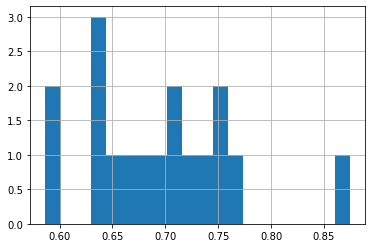

In [66]:
d1_fitness.T.hybA.hist(bins=20)

In [78]:
cnt_df[cnt_df.phenotype == 'hyb']

,barcode,ShortName,locus_tag,phenotype,conc
500,TTCGTACACCATGAGGT,NaN,NaN,hyb,0.001500
523,GGCGTGACTGCAAGGGC,NaN,NaN,hyb,0.000500
548,AAAATGCGCACTACGAA,NaN,NaN,hyb,0.000167
562,AACCATGATACAACAAT,NaN,NaN,hyb,0.000056
570,AGACAGGTAGAGGCCAT,NaN,NaN,hyb,0.000019
